In [71]:
import math
import sys

import boto3
import numpy as np

sys.path.append('../')
sys.path.append('../../')
from run_utils import get_env_dataset, run_env_experiment, plot_ratings_mses
from run_utils import s3_experiment_dir_name, s3_load_trial_quick
from reclab.environments import Topics, LatentFactorBehavior
from env_defaults import *
from reclab.recommenders import TopPop


In [88]:
# S3 storage parameters
bucket_name = 'recsys-eval'
bucket = boto3.resource('s3').Bucket(bucket_name)
data_dir = 'master'
overwrite = False

env_name = 'latent_dynamic' #'topics_static'

if env_name == 'topics_static':
    ENV_PARAMS = TOPICS_STATIC
    EnvObj = Topics
elif env_name == 'topics_dynamic':
    ENV_PARAMS = TOPICS_DYNAMIC
    EnvObj = Topics
elif env_name == 'latent_static':
    ENV_PARAMS = LATENT_STATIC
    EnvObj = LatentFactorBehavior
elif env_name == 'latent_dynamic':
    ENV_PARAMS = LATENT_DYNAMIC
    EnvObj = LatentFactorBehavior
elif env_name == 'topics_static_small':
    ENV_PARAMS = TOPICS_STATIC_SMALL
    EnvObj = Topics
elif env_name == 'topics_dynamic_small':
    ENV_PARAMS = TOPICS_DYNAMIC_SMALL
    EnvObj = Topics
elif env_name == 'latent_static_small':
    ENV_PARAMS = LATENT_STATIC_SMALL
    EnvObj = LatentFactorBehavior
elif env_name == 'latent_dynamic_small':
    ENV_PARAMS = LATENT_DYNAMIC_SMALL
    EnvObj = LatentFactorBehavior
else:
    assert False, "environment not implemented!"


# Experiment setup.
n_trials = 3
trial_seeds = [i for i in range(n_trials)]
num_init_ratings = ENV_PARAMS['optional_params']['num_init_ratings']

environment_name = ENV_PARAMS['name']
env_name = ENV_PARAMS['name']

# Recommender setup
recommender_names = ['PerfectRec', 'TopPop', 'RandomRec', 'EASE']

In [89]:
all_ratings = []
all_predictions = []
for rec_name in recommender_names:
    all_ratings.append([])
    all_predictions.append([])
    print('Loading trials for recommender:', rec_name)
    for seed in trial_seeds:

        print('Loading trial with seed:', seed)
        dir_name = s3_experiment_dir_name(data_dir, env_name, rec_name, seed)
        ratings, predictions = s3_load_trial_quick(bucket, dir_name)
        all_ratings[-1].append(ratings)
        all_predictions[-1].append(predictions)


Loading trials for recommender: PerfectRec
Loading trial with seed: 0
Loading trial with seed: 1
Loading trial with seed: 2
Loading trials for recommender: TopPop
Loading trial with seed: 0
Loading trial with seed: 1
Loading trial with seed: 2
Loading trials for recommender: RandomRec
Loading trial with seed: 0
Loading trial with seed: 1
Loading trial with seed: 2
Loading trials for recommender: EASE
Loading trial with seed: 0
Loading trial with seed: 1
Loading trial with seed: 2


In [90]:
all_ratings = np.array(all_ratings)
all_predictions = np.array(all_predictions)

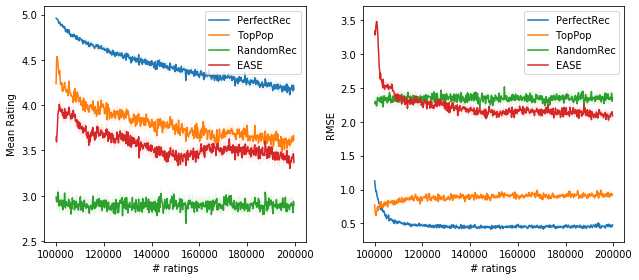

In [91]:
plot_ratings_mses(all_ratings,
                      all_predictions,
                      recommender_names,
                      summary_type='mean',
                      num_init_ratings=num_init_ratings, threshold=10)

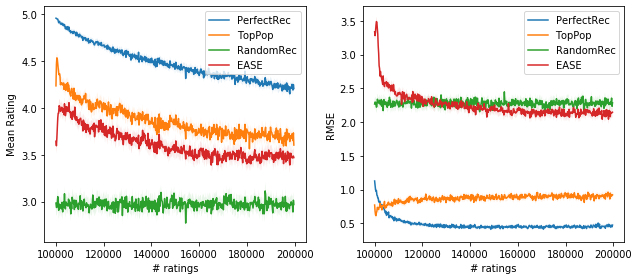

In [87]:
plot_ratings_mses(all_ratings,
                      all_predictions,
                      recommender_names,
                      summary_type='mean',
                      num_init_ratings=num_init_ratings, threshold=10)